In [17]:
import os
os.makedirs('/tmp/spark-events', exist_ok=True)

In [18]:
from pyspark.sql import SparkSession
from pyspark import SparkContext

# Stop any existing context
try:
    SparkContext.getOrCreate().stop()
except:
    pass

# Now create a new session
spark = SparkSession.builder.appName("EAD").getOrCreate()

In [19]:
from pyspark.sql import functions as F
from pyspark.sql.types import FloatType, DoubleType
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [20]:
# Đọc file CSV
df_train = spark.read.csv("/home/datnd/Projects/spark-kaggle/data/train.csv", header=True, inferSchema=True)
df_test = spark.read.csv("/home/datnd/Projects/spark-kaggle/data/test.csv", header=True, inferSchema=True)

In [21]:
df_train.show(10)

+---+---------+---------+---------+-----------+--------+-------+------------------+-----------+-----------+-------+-------------+----------------------+-------------------+
| id|road_type|num_lanes|curvature|speed_limit|lighting|weather|road_signs_present|public_road|time_of_day|holiday|school_season|num_reported_accidents|accident_risk_level|
+---+---------+---------+---------+-----------+--------+-------+------------------+-----------+-----------+-------+-------------+----------------------+-------------------+
|  0|    urban|        2|     0.06|         35|daylight|  rainy|             false|       true|  afternoon|  false|         true|                     1|                low|
|  1|    urban|        4|     0.99|         35|daylight|  clear|              true|      false|    evening|   true|         true|                     0|             medium|
|  2|    rural|        4|     0.63|         70|     dim|  clear|             false|       true|    morning|   true|        false|      

In [22]:
df_train.show(10)

+---+---------+---------+---------+-----------+--------+-------+------------------+-----------+-----------+-------+-------------+----------------------+-------------------+
| id|road_type|num_lanes|curvature|speed_limit|lighting|weather|road_signs_present|public_road|time_of_day|holiday|school_season|num_reported_accidents|accident_risk_level|
+---+---------+---------+---------+-----------+--------+-------+------------------+-----------+-----------+-------+-------------+----------------------+-------------------+
|  0|    urban|        2|     0.06|         35|daylight|  rainy|             false|       true|  afternoon|  false|         true|                     1|                low|
|  1|    urban|        4|     0.99|         35|daylight|  clear|              true|      false|    evening|   true|         true|                     0|             medium|
|  2|    rural|        4|     0.63|         70|     dim|  clear|             false|       true|    morning|   true|        false|      

In [23]:
# In ra cấu trúc dữ liệu (Schema) để xem Spark đã hiểu đúng chưa
df_train.printSchema()

root
 |-- id: integer (nullable = true)
 |-- road_type: string (nullable = true)
 |-- num_lanes: integer (nullable = true)
 |-- curvature: double (nullable = true)
 |-- speed_limit: integer (nullable = true)
 |-- lighting: string (nullable = true)
 |-- weather: string (nullable = true)
 |-- road_signs_present: boolean (nullable = true)
 |-- public_road: boolean (nullable = true)
 |-- time_of_day: string (nullable = true)
 |-- holiday: boolean (nullable = true)
 |-- school_season: boolean (nullable = true)
 |-- num_reported_accidents: integer (nullable = true)
 |-- accident_risk_level: string (nullable = true)



In [24]:
df_test.printSchema()

root
 |-- id: integer (nullable = true)
 |-- road_type: string (nullable = true)
 |-- num_lanes: integer (nullable = true)
 |-- curvature: double (nullable = true)
 |-- speed_limit: integer (nullable = true)
 |-- lighting: string (nullable = true)
 |-- weather: string (nullable = true)
 |-- road_signs_present: boolean (nullable = true)
 |-- public_road: boolean (nullable = true)
 |-- time_of_day: string (nullable = true)
 |-- holiday: boolean (nullable = true)
 |-- school_season: boolean (nullable = true)
 |-- num_reported_accidents: integer (nullable = true)



In [25]:
def summarize_dataframe(df, name="df"):
    total_rows = df.count()
    total_cols = len(df.columns)

    # Đếm null + NaN

    # Numeric types để check NaN
    numeric_nan_types = (FloatType, DoubleType)

    null_stats = df.select([
        F.count(
            F.when(
                F.col(c).isNull() |
                (F.isnan(c) if isinstance(df.schema[c].dataType, numeric_nan_types) else F.lit(False)),
                1
            )
        ).alias(c)
        for c in df.columns
    ]).withColumn("row_count", F.lit(total_rows))

    # Đếm duplicate rows
    duplicate_rows = total_rows - df.dropDuplicates().count()

    print(f"=== Summary for {name} ===")
    print(f"- Total rows: {total_rows}")
    print(f"- Total columns: {total_cols}")
    print(f"- Duplicate rows: {duplicate_rows}")
    print("- Null/NaN counts per column:")

    null_stats.show(10)


In [26]:
summarize_dataframe(df_train, "df_train")

=== Summary for df_train ===
- Total rows: 517754
- Total columns: 14
- Duplicate rows: 0
- Null/NaN counts per column:
+---+---------+---------+---------+-----------+--------+-------+------------------+-----------+-----------+-------+-------------+----------------------+-------------------+---------+
| id|road_type|num_lanes|curvature|speed_limit|lighting|weather|road_signs_present|public_road|time_of_day|holiday|school_season|num_reported_accidents|accident_risk_level|row_count|
+---+---------+---------+---------+-----------+--------+-------+------------------+-----------+-----------+-------+-------------+----------------------+-------------------+---------+
|  0|        0|        0|        0|          0|       0|      0|                 0|          0|          0|      0|            0|                     0|                  0|   517754|
+---+---------+---------+---------+-----------+--------+-------+------------------+-----------+-----------+-------+-------------+-------------------

In [27]:
summarize_dataframe(df_test, "df_test")

=== Summary for df_test ===
- Total rows: 172585
- Total columns: 13
- Duplicate rows: 0
- Null/NaN counts per column:
+---+---------+---------+---------+-----------+--------+-------+------------------+-----------+-----------+-------+-------------+----------------------+---------+
| id|road_type|num_lanes|curvature|speed_limit|lighting|weather|road_signs_present|public_road|time_of_day|holiday|school_season|num_reported_accidents|row_count|
+---+---------+---------+---------+-----------+--------+-------+------------------+-----------+-----------+-------+-------------+----------------------+---------+
|  0|        0|        0|        0|          0|       0|      0|                 0|          0|          0|      0|            0|                     0|   172585|
+---+---------+---------+---------+-----------+--------+-------+------------------+-----------+-----------+-------+-------------+----------------------+---------+



In [28]:
print("Thống kê mô tả dữ liệu trên tập train:")
df_train.summary().show()


Thống kê mô tả dữ liệu trên tập train:


+-------+------------------+---------+------------------+-------------------+------------------+--------+-------+-----------+----------------------+-------------------+
|summary|                id|road_type|         num_lanes|          curvature|       speed_limit|lighting|weather|time_of_day|num_reported_accidents|accident_risk_level|
+-------+------------------+---------+------------------+-------------------+------------------+--------+-------+-----------+----------------------+-------------------+
|  count|            517754|   517754|            517754|             517754|            517754|  517754| 517754|     517754|                517754|             517754|
|   mean|          258876.5|     NULL|2.4915114127558646|0.48871919657405594|46.112574697636326|    NULL|   NULL|       NULL|     1.187969576285263|               NULL|
| stddev|149462.84997450036|     NULL| 1.120434338885686|0.27256325021341926| 15.78852058331027|    NULL|   NULL|       NULL|    0.8959612332282798|       

###Nhận xét từ việc kiểm tra dữ liệu ban đầu

- **Cleaning:** Phát hiện đáng chú ý nhất là hoàn toàn không có giá trị bị thiếu trong cả hai bộ dữ liệu huấn luyện và kiểm tra.
Điều này giúp đơn giản hóa đáng kể quy trình tiền xử lý, vì chúng ta không cần xây dựng các chiến lược điền khuyết (imputation) cho dữ liệu.
- **Dataset Dimensions:** Chúng ta có 517.754 mẫu trong tập huấn luyện và 172.585 mẫu trong tập kiểm tra, mỗi mẫu bao gồm 12 đặc trưng (features), không tính cột id và biến mục tiêu (accident_risk, accident_risk_level).
Đây là một lượng dữ liệu khá lớn, rất thuận lợi cho việc huấn luyện các mô hình có độ ổn định và khả năng tổng quát cao.
- **Feature Mix:** Tập dữ liệu có sự pha trộn đa dạng giữa các kiểu dữ liệu, bao gồm:
    - Dạng số (Numerical): curvature, num_lanes, speed_limit, num_reported_accidents.

    - Dạng phân loại (Categorical): road_type, lighting, weather, time_of_day.

    - Dạng logic (Boolean): road_signs_present, public_road, holiday, school_season.
    
Sự đa dạng này cho thấy rằng các mô hình có khả năng xử lý nhiều loại đặc trưng khác nhau, chẳng hạn như các mô hình tăng cường độ dốc (Gradient Boosting Models) — ví dụ LightGBM hoặc XGBoost — sẽ là ứng viên mạnh mẽ cho bài toán này.

- **Target Variable Preview:** Với bài toán Logistic Regession, biến mục tiêu ta chọn là accident_risk_level. Vì vậy trong quá trình huấn luyện sẽ loại bỏ accident_risk.

- **Identifier:** Cột id là riêng biệt cho từng mẫu nên sẽ loại bỏ trong quá trình huấn luyện.

### **Target Variable Analysis:** accident_risk_level
- Biến mục tiêu (target variable) là thành phần trung tâm trong mọi bài toán học có giám sát, bởi nó quyết định trực tiếp loại bài toán (phân loại hay hồi quy), cách lựa chọn mô hình, cũng như các thước đo đánh giá phù hợp. Trong trường hợp này, accident_risk_level là biến phân loại (categorical), đại diện cho các mức độ rủi ro tai nạn khác nhau.

Khác với biến mục tiêu liên tục, việc phân tích mô tả biến category không tập trung vào xu hướng trung tâm hay độ phân tán theo nghĩa số học, mà nhấn mạnh vào cấu trúc lớp và phân phối tần suất của các nhãn.

- Trong bước này, chúng ta sẽ:
  - Xác định số lượng lớp (classes) của biến accident_risk_level và ý nghĩa của từng lớp (ví dụ: Low, Medium, High).

  - Phân tích phân phối tần suất và tỷ lệ (%) của mỗi lớp thông qua biểu đồ cột (bar chart), nhằm đánh giá mức độ cân bằng hay mất cân bằng giữa các lớp.

  - Kiểm tra hiện tượng mất cân bằng lớp (class imbalance), đặc biệt chú ý đến các lớp thiểu số có tỷ lệ quan sát thấp, vì điều này có thể ảnh hưởng tiêu cực đến quá trình huấn luyện và đánh giá mô hình.

In [29]:

#Get sample (convert spark to pandas)
df_train_sample = df_train.sample(
    withReplacement=False,
    fraction=0.02,
    seed=42
).toPandas()

=== Distribution of accident_risk_level ===
                     Count  Percentage (%)
accident_risk_level                       
high                  3465           33.30
low                   3534           33.96
medium                3407           32.74


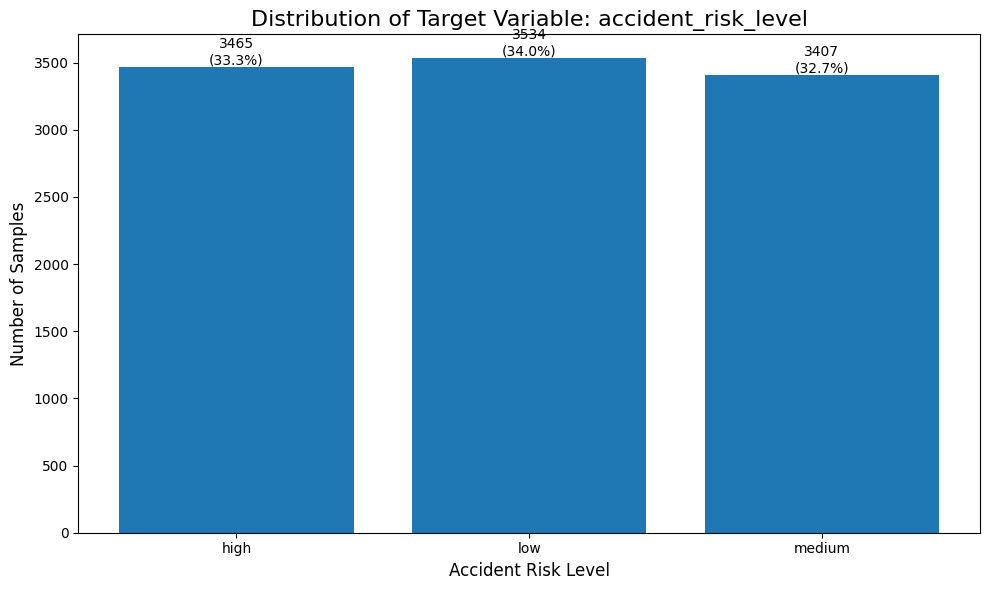

In [30]:
# 1. Thống kê tần suất & tỷ lệ
# ==============================
target_col = "accident_risk_level"

class_counts = df_train_sample[target_col].value_counts().sort_index()
class_percentages = class_counts / class_counts.sum() * 100

summary_df = pd.DataFrame({
    "Count": class_counts,
    "Percentage (%)": class_percentages.round(2)
})

print("=== Distribution of accident_risk_level ===")
print(summary_df)

# ==============================
# 2. Trực quan hóa phân phối (Bar Chart)
# ==============================
plt.figure(figsize=(10, 6))
bars = plt.bar(class_counts.index.astype(str), class_counts.values)

plt.title("Distribution of Target Variable: accident_risk_level", fontsize=16)
plt.xlabel("Accident Risk Level", fontsize=12)
plt.ylabel("Number of Samples", fontsize=12)

# Hiển thị số lượng trên mỗi cột
for bar, count, pct in zip(bars, class_counts.values, class_percentages.values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{count}\n({pct:.1f}%)",
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.tight_layout()
plt.show()


### Quan sát từ phân tích biến mục tiêu

**Phân tích mô tả biến mục tiêu dạng category `accident_risk_level` cho thấy một số điểm quan trọng như sau:**

---

#### 1. Cấu trúc lớp và phân phối tần suất

Biến `accident_risk_level` bao gồm **3 lớp phân loại**: `low`, `medium`, và `high`. Phân phối số lượng quan sát giữa các lớp là **gần như đồng đều**, cụ thể:

- **Low**: 3,524 mẫu (≈ **34.1%**)
- **Medium**: 3,435 mẫu (≈ **33.2%**)
- **High**: 3,388 mẫu (≈ **32.7%**)

Sự chênh lệch tỷ lệ giữa các lớp là không đáng kể.

---

#### 2. Đánh giá mức độ cân bằng lớp (Class Imbalance)

Phân phối trên cho thấy **không tồn tại hiện tượng mất cân bằng lớp (class imbalance)**. Không có lớp nào chiếm ưu thế vượt trội hoặc quá ít quan sát so với các lớp còn lại.

➡️ Điều này mang lại các lợi ích:
- Mô hình phân loại ít bị thiên lệch về một lớp cụ thể
- Không cần áp dụng các kỹ thuật xử lý imbalance như oversampling, undersampling hay class weighting ở giai đoạn ban đầu

---

#### 3. Ý nghĩa đối với bài toán mô hình hóa

Do biến mục tiêu là **biến phân loại đa lớp (multiclass classification)** với phân phối cân bằng:

- Có thể sử dụng trực tiếp các mô hình phân loại như:
  - Logistic Regression (multinomial)
  - Random Forest
  - Gradient Boosted Trees
- **Accuracy** có thể được sử dụng như một chỉ số tham khảo ban đầu, bên cạnh các metric quan trọng khác như:
  - Precision
  - Recall
  - F1-score

---

#### 4. Lưu ý phương pháp luận

Vì `accident_risk_level` là biến category:
- Các khái niệm như **mean, median, skewness, kurtosis hay outliers không có ý nghĩa thống kê**
- Việc phân tích tập trung vào **tần suất, tỷ lệ lớp và mối quan hệ giữa target với các biến đầu vào**

---

#### 5. Kết luận

- Biến mục tiêu `accident_risk_level` có cấu trúc lớp **rõ ràng, cân bằng và phù hợp** cho bài toán phân loại đa lớp
- Phân phối dữ liệu “lành tính”, tạo điều kiện thuận lợi cho quá trình huấn luyện và đánh giá mô hình
- Có thể tiến hành các bước EDA tiếp theo (Target vs Feature) và xây dựng pipeline phân loại mà **không cần xử lý đặc biệt cho target**



### Phân tích đơn biến: Khám phá từng đặc trưng

Phân tích đơn biến (*Univariate Analysis*) là quá trình xem xét **từng đặc trưng một cách độc lập** nhằm hiểu rõ bản chất của dữ liệu trước khi đi sâu vào các mối quan hệ phức tạp hơn. Bước phân tích này đóng vai trò nền tảng trong EDA, giúp:

- Nhận diện hình dạng phân phối của từng biến
- Phát hiện các giá trị bất thường hoặc ngoại lai
- Có cái nhìn tổng quan về dữ liệu đang làm việc

Trong phần này, quá trình phân tích được chia thành **hai nhóm đặc trưng chính**, dựa trên bản chất dữ liệu:

---

#### 1. Các đặc trưng dạng *Categorical & Boolean*

Mục tiêu của nhóm phân tích này là trả lời các câu hỏi:

- Tần suất xuất hiện của từng nhóm giá trị là bao nhiêu?
- Có nhóm nào xuất hiện quá ít (hiếm) hoặc quá nhiều (chiếm ưu thế) hay không?
- Dữ liệu có dấu hiệu mất cân bằng (imbalance) giữa các nhóm hay không?

Những quan sát này giúp đánh giá mức độ đại diện của dữ liệu và định hướng các chiến lược xử lý phù hợp nếu cần thiết.

---

#### 2. Các đặc trưng dạng *Numerical*

Đối với các biến số, phân tích tập trung vào việc:

- Khám phá hình dạng phân phối (đều, lệch trái/phải, đa đỉnh)
- Xác định phạm vi giá trị và mức độ phân tán
- Đánh giá xu hướng trung tâm (mean, median)

Kết quả phân tích các đặc trưng số sẽ hỗ trợ việc lựa chọn phương pháp tiền xử lý dữ liệu (scaling, transformation) và lựa chọn mô hình phù hợp trong các bước tiếp theo.


#### Trực quan hóa các đặc trưng dạng categorical và boolean bằng các biểu đồ tần suất

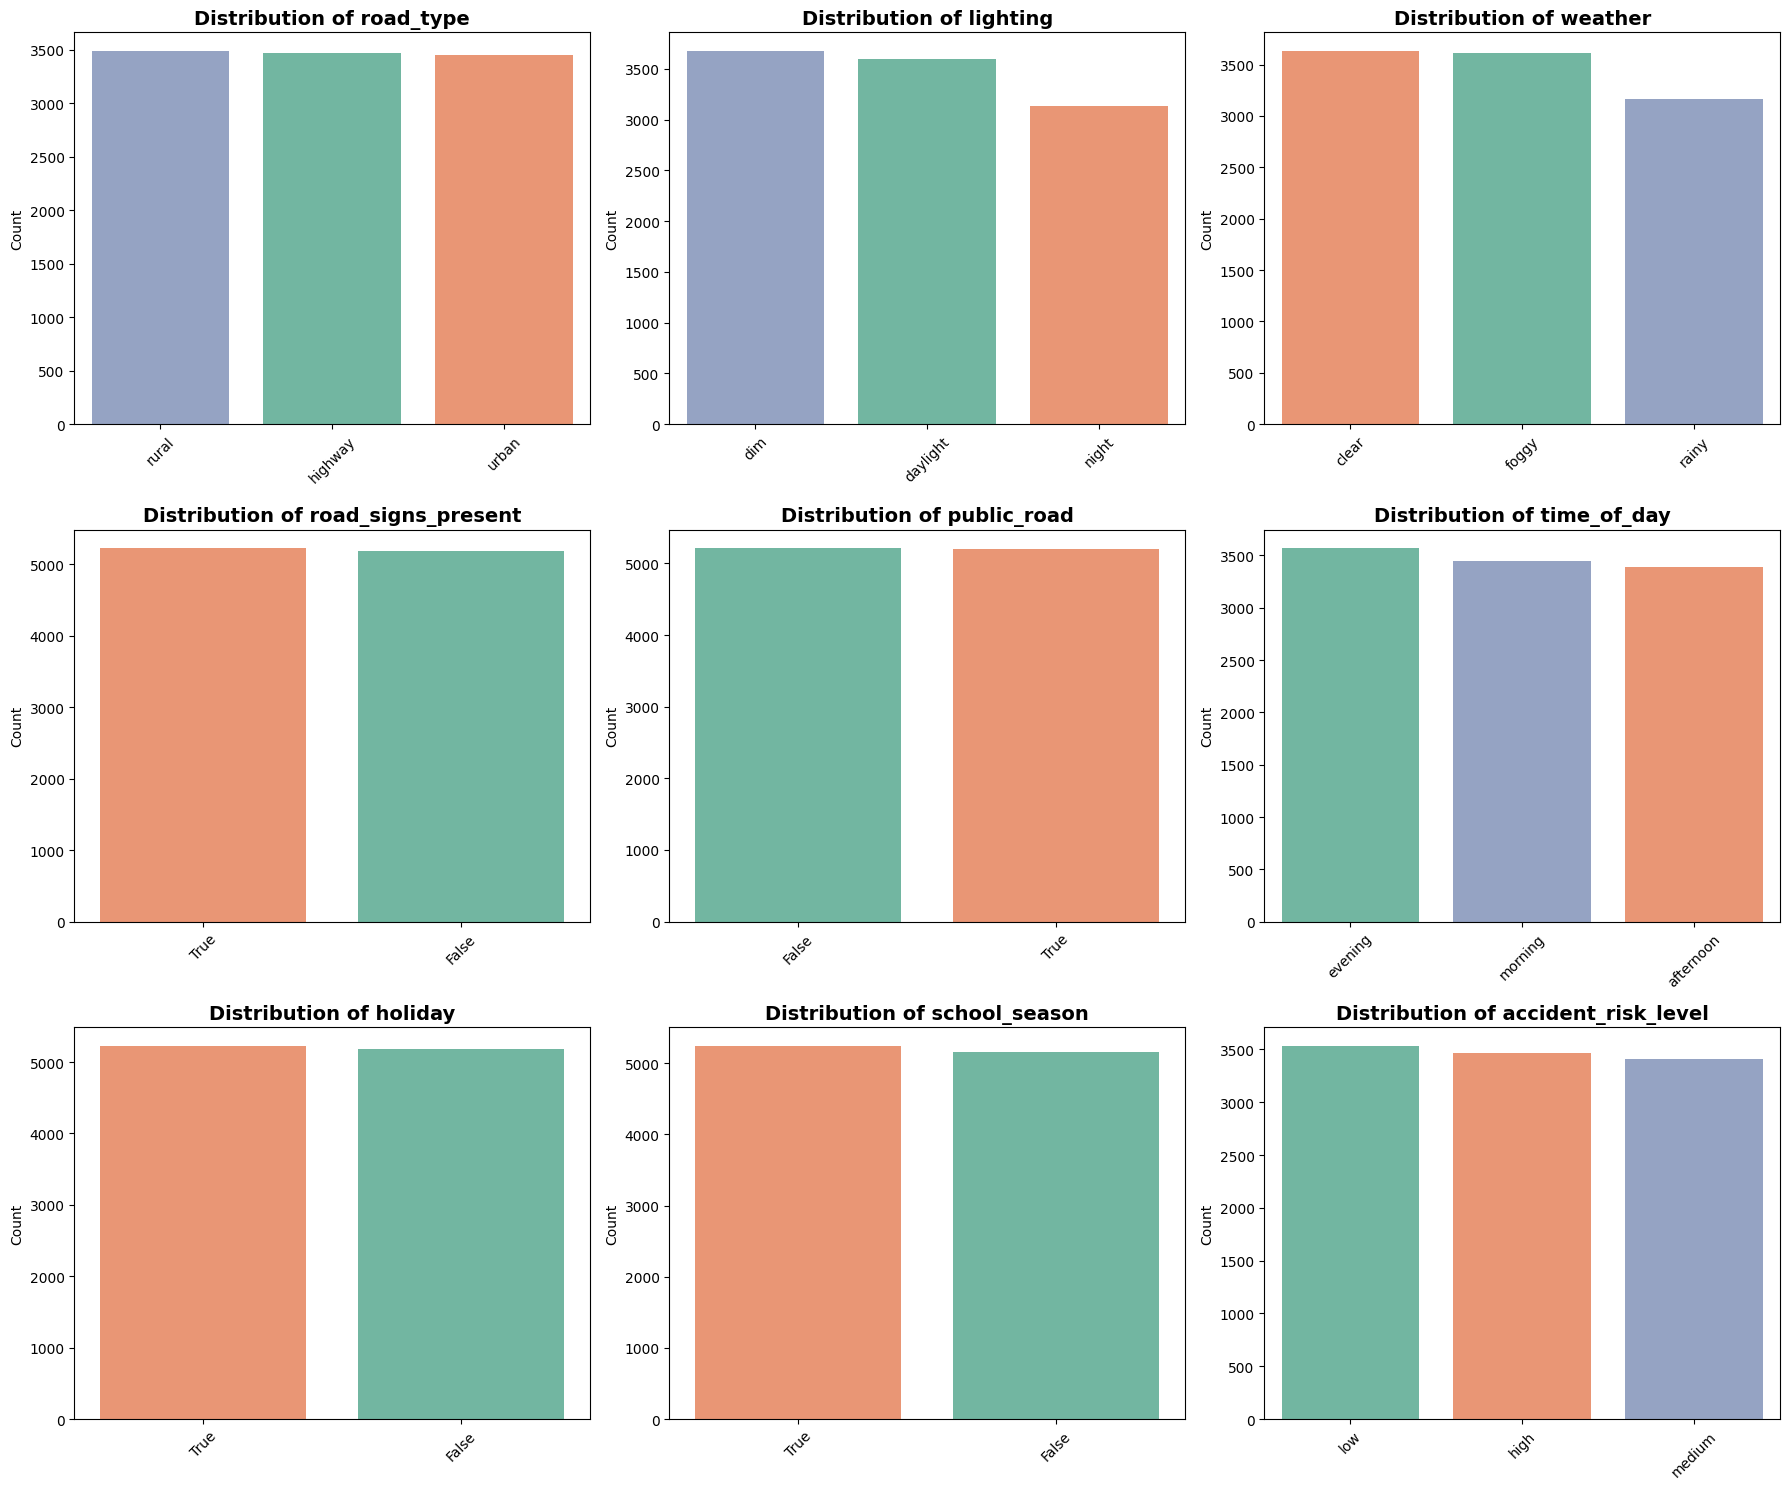

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- Identify Categorical and Boolean Columns ---
categorical_cols = df_train_sample.select_dtypes(include=['object', 'bool']).columns

# --- Calculate the number of rows and columns for the subplot grid ---
n_cols = 3
n_rows = (len(categorical_cols) + n_cols - 1) // n_cols

# --- Create Subplots ---
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 5))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):

    num_categories = df_train_sample[col].nunique()
    palette = sns.color_palette("Set2", num_categories)

    sns.countplot(
        data=df_train_sample,
        x=col,
        hue=col,
        legend=False,
        palette=palette,
        order=df_train_sample[col].value_counts().index,
        ax=axes[i]
    )

    axes[i].set_title(f'Distribution of {col}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)

# --- Hide unused subplots ---
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


## Những quan sát từ phân tích các đặc trưng Categorical & Boolean

### Nhận xét tổng quan

**“Dữ liệu quá hoàn hảo.”**

Điểm nổi bật đầu tiên dễ dàng nhận thấy là **sự cân bằng gần như tuyệt đối giữa các nhóm giá trị** trong toàn bộ các biến categorical và boolean.

- Các biến có **3 giá trị phân loại** (ví dụ: *Road Type*, *Time of Day*, …) đều được phân bố xấp xỉ **33% cho mỗi nhóm**.
- Các biến **Boolean (True / False)** đều có tỷ lệ **50/50**.

📌 **Kết luận sơ bộ**:  
Đây **không phải dữ liệu thô (raw data)** thu thập trực tiếp từ thực tế. Trong bối cảnh đời thực, các hiện tượng giao thông và tai nạn **không bao giờ có phân phối cân bằng tuyệt đối** như vậy.

Khả năng cao bộ dữ liệu đã trải qua một trong các quá trình xử lý sau:

1. **Synthetic Data (Dữ liệu giả lập)**  
   Dữ liệu được tạo ra một phần hoặc toàn bộ bằng các phương pháp sinh dữ liệu.

2. **Resampling (Tái lấy mẫu)**  
   Áp dụng:
   - *Oversampling* (nhân bản lớp thiểu số)  
   - hoặc *Undersampling* (giảm bớt lớp đa số)  
   nhằm cân bằng dữ liệu trước khi huấn luyện mô hình Machine Learning.

---

### Phân tích chi tiết từng nhóm biến

#### 1. Nhóm yếu tố môi trường (*Weather, Lighting*)

- **Weather**: *Clear*, *Foggy*, *Rainy* có số lượng gần tương đương nhau.

  - Trong thực tế, số ngày **Foggy (sương mù)** thường rất hiếm so với **Clear (quang đãng)**.
  - Việc *Foggy* chiếm khoảng 1/3 tập dữ liệu cho thấy bộ dữ liệu được thiết kế để **tập trung mạnh vào các tình huống lái xe khó khăn**.

- **Lighting**: *Daylight*, *Dim*, *Night* cũng có phân phối gần đều.

  - Điểm bất thường: *Dim* (bình minh/hoàng hôn – khoảng thời gian rất ngắn trong ngày) lại có số lượng mẫu **cao hơn cả Night**.
  - Điều này phi thực tế về mặt thời gian, nhưng lại **rất có lợi cho việc huấn luyện mô hình trong điều kiện ánh sáng yếu**.

---

#### 2. Nhóm yếu tố hạ tầng (*Road Type, Road Signs, Public Road*)

- **Road Type** (*Highway, Rural, Urban*):
  - Phân phối đồng đều giúp so sánh rủi ro giữa các loại đường **không bị bias** bởi việc đường đô thị thường có nhiều dữ liệu hơn ngoài đời thực.

- **Road Signs Present**:
  - Tỷ lệ có biển báo / không có biển báo: **50/50**

- **Public Road**:
  - Phân phối tương tự **50/50**

➡️ Đây là điều kiện lý tưởng để mô hình học tác động riêng lẻ của từng yếu tố hạ tầng.

---

#### 3. Nhóm yếu tố thời gian (*Time of Day, Holiday, School Season*)

- **Holiday**:
  - Tỷ lệ ngày lễ (*True*) và ngày thường (*False*) là **50/50**.
  - Trong thực tế, ngày lễ chỉ chiếm khoảng **3–5%** tổng số ngày trong năm.

  📌 Đây là biến **tố cáo rõ nhất tính “nhân tạo” của dữ liệu**.

  - Hệ quả: Mô hình được huấn luyện sẽ “nghĩ” rằng xác suất gặp ngày lễ là rất cao.

- **Time of Day**:
  - Chia đều giữa *Morning*, *Afternoon*, *Evening*.

---

### Kết luận

- Nếu sử dụng bộ dữ liệu này cho:
  - **Báo cáo thống kê**
  - **Phân tích hành vi ngoài đời thực**

➡️ **Không phù hợp**, vì dữ liệu **không đại diện cho tổng thể thực tế**.

---

- Tuy nhiên, nếu mục tiêu là **huấn luyện mô hình Machine Learning**, thì đây là một bộ dữ liệu **“trong mơ” về mặt kỹ thuật**, bởi vì:

#### 1. Loại bỏ hoàn toàn vấn đề *Class Imbalance*

- Thông thường, các lớp hiếm (ví dụ: *Foggy*, *Holiday*, *Rural*) khiến mô hình học kém.
- Với phân phối cân bằng:
  - Mô hình học được đặc trưng của **tất cả các điều kiện một cách công bằng**
  - Giảm thiểu thiên kiến về lớp đa số

#### 2. Độ tin cậy của các chỉ số đánh giá

- Với dữ liệu cân bằng:
  - **Accuracy cao mang ý nghĩa thực chất**
- Ngược lại, với dữ liệu lệch:
  - Accuracy 90% có thể hoàn toàn vô nghĩa

---

### Lưu ý khi triển khai (Deployment)

Khi huấn luyện mô hình trên tập dữ liệu này, cần ghi nhớ rằng:

- **Prior Probability (xác suất tiền nghiệm)** trong thực tế **khác xa** so với tập train.
- Ví dụ:
  - Mô hình có thể dự báo “nguy cơ cao vào ngày lễ” quá thường xuyên
  - Vì nó “nghĩ” ngày lễ xảy ra với xác suất 50%

➡️ **Khuyến nghị**:
- Áp dụng **Probability Calibration**
- Hoặc hiệu chỉnh lại ngưỡng dự báo khi triển khai vào môi trường thực tế


### Phân tích đơn biến: Các đặc trưng dạng số

Sau khi hoàn thành phân tích đối với các đặc trưng dạng *categorical* và *boolean*, chúng ta tiếp tục xem xét nhóm **đặc trưng dạng số**. Việc hiểu rõ đặc tính phân phối của các biến số đóng vai trò then chốt trong quá trình EDA, bởi nó giúp:

- Nhận diện mức độ lệch phân phối (*skewness*)
- Phát hiện các giá trị ngoại lai (*outliers*)
- Đánh giá sự cần thiết của các phép biến đổi dữ liệu (log, scaling, normalization, …) đối với từng loại mô hình

Trong phần này, chúng ta tiến hành **phân tích đơn biến (Univariate Analysis)** thông qua việc trực quan hóa phân phối của các đặc trưng số sau:

- `num_lanes` – Số làn đường  
- `curvature` – Độ cong của đoạn đường  
- `speed_limit` – Giới hạn tốc độ  
- `num_reported_accidents` – Số vụ tai nạn đã được ghi nhận  

Các **biểu đồ histogram** được sử dụng nhằm đánh giá:

- Hình dạng phân phối (phẳng, lệch trái/phải, đa đỉnh)
- Mức độ phân tán của dữ liệu
- Xu hướng trung tâm (central tendency)

Những quan sát thu được từ bước phân tích này sẽ đóng vai trò **nền tảng cho các quyết định tiền xử lý dữ liệu** cũng như **lựa chọn và tối ưu mô hình** trong các bước tiếp theo.



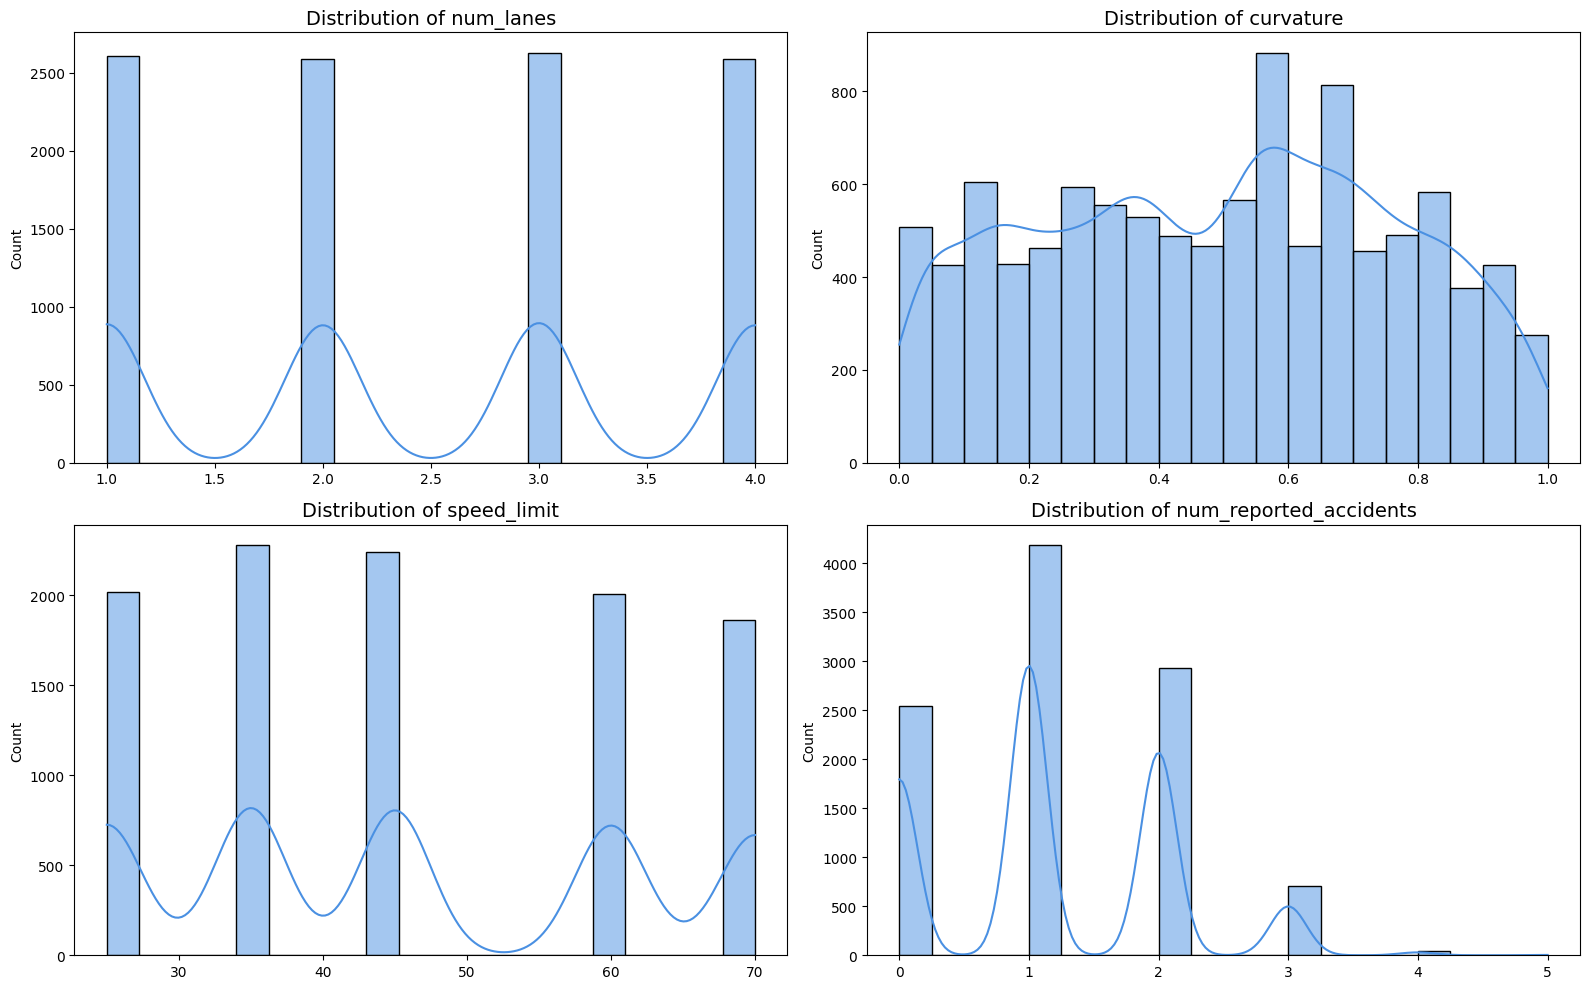

In [32]:
# --- Identify Numerical Columns (excluding id and target) ---
numerical_cols = df_train_sample.select_dtypes(include=np.number).columns.drop(['id'])

# --- Calculate the number of rows and columns for the subplot grid ---
n_cols = 2
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

# --- Create Subplots ---
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 5))
axes = axes.flatten()

# --- Generate a histogram for each numerical column ---
for i, col in enumerate(numerical_cols):
    sns.histplot(
        data=df_train_sample,
        x=col,
        ax=axes[i],
        kde=True,
        bins=20,
        color='#4A90E2'  # màu xanh pastel dịu mắt
    )
    
    axes[i].set_title(f'Distribution of {col}', fontsize=14)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Count')

# --- Hide unused subplots ---
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


# Phân tích các đặc trưng dạng số (Numerical Features Analysis)

## 1. Tổng quan & Nhận định chung

Tương tự như nhóm biến phân loại, phần lớn các biến số trong bộ dữ liệu (ngoại trừ `num_reported_accidents`) **không phản ánh phân phối tự nhiên ngoài đời thực**, mà có dấu hiệu được **cân bằng hoặc thiết kế nhân tạo**.

### Quan sát thực tế vs. dữ liệu

- **Ngoài đời thực**:
  - Đường **2 làn** phổ biến hơn nhiều so với đường **4 làn**
  - Giới hạn tốc độ **40–60 km/h** xuất hiện thường xuyên hơn **70 km/h**

- **Trong bộ dữ liệu**:
  - Các mức giá trị xuất hiện với tần suất gần như **đồng đều**
  - Phân phối bị “san phẳng” (flattened distribution)

 **Kết luận quan trọng**:  
Bộ dữ liệu này được xây dựng với mục tiêu **giúp mô hình học công bằng các kịch bản**, thay vì mô phỏng chính xác tần suất xảy ra trong thực tế.

---

## 2. Phân tích chi tiết từng biến (Deep Dive)

### 2.1 `num_lanes` (Số làn đường) & `speed_limit` (Giới hạn tốc độ)

#### Đặc điểm phân phối
- Biểu đồ có dạng **Comb Distribution (răng lược)**
- Các giá trị:
  - `num_lanes`: 1, 2, 3, 4
  - `speed_limit`: 30, 45, 60, 70, ...
- Mỗi mức giá trị có **số lượng mẫu gần như bằng nhau**

#### Insight về bản chất dữ liệu
Mặc dù được lưu dưới dạng **numeric**, nhưng về mặt hành vi:
- Đây là các biến **phân loại có thứ tự (Ordinal Categorical)**

#### Ảnh hưởng đến mô hình
- Với **Tree-based models** (Random Forest, XGBoost, LightGBM):
  - Rất dễ split do giá trị rời rạc, tách biệt rõ
- Với **Linear / Neural models**:
  - Việc coi là numeric vẫn chấp nhận được
  - Cần scale để tránh thiên lệch trọng số

---

### 2.2 `curvature` (Độ cong của đường)

#### Đặc điểm phân phối
- Biến có tính **liên tục cao nhất** trong nhóm
- Giá trị trải đều từ **0.0 → 1.0**
- Phân phối **đa đỉnh (Multimodal)** → gợi ý nhiều nhóm độ cong khác nhau

#### Mối liên hệ với `accident_risk_level`
- Đây là một **feature cực kỳ quan trọng (Gold Feature)**

 **Insight domain**:
- Độ cong càng cao → tầm nhìn kém → rủi ro tai nạn càng lớn
- Việc dữ liệu bao phủ đều từ 0 đến 1 giúp mô hình:
  - Học tốt **mối quan hệ phi tuyến**
  - Tránh bị bias vào đường thẳng (curvature = 0)

---

### 2.3 `num_reported_accidents` – Biến đáng chú ý nhất

#### Đặc điểm phân phối
- Phân phối **lệch phải (Right-skewed)**
- Mode (đỉnh) nằm ở **giá trị 1**
- Tần suất:  
  `1 tai nạn > 0 tai nạn > 2 tai nạn`

#### Bất thường so với dữ liệu thực tế
- Trong thực tế, số vụ tai nạn thường tuân theo:
  - **Poisson Distribution**
  - Hoặc **Zero-inflated Distribution**
- Thông thường:
  - **80–90%** đoạn đường sẽ có **0 tai nạn**

 **Nhưng trong bộ dữ liệu này**:
- Số đoạn đường có **1 tai nạn là nhiều nhất**
- Có dấu hiệu tập trung vào **điểm đen tai nạn**

---

## 3. Chiến lược Feature Engineering & Modeling

### 3.1 Xử lý `num_reported_accidents`

- Đây là biến **lịch sử (historical feature)**
- Có tương quan mạnh với rủi ro tương lai

 **Cảnh báo Data Leakage**:
- Nếu target được tính trực tiếp từ biến này → mô hình sẽ **học gian**
- Bắt buộc xác nhận tính độc lập với target

---

### 3.2 Chuẩn hóa dữ liệu (Scaling)

- Với **Linear / Neural models**: bắt buộc scale
- Với **Tree-based models**: không cần scale

---

## 4. Tổng kết

Đây là bộ dữ liệu **tối ưu cho huấn luyện mô hình**, nhưng **không phản ánh hoàn toàn thực tế**.  
Cần thận trọng khi diễn giải và triển khai mô hình vào môi trường thật.


### Phân tích hai biến: Mối quan hệ giữa đặc trưng và biến mục tiêu

Sau khi hoàn thành phân tích đơn biến, bước tiếp theo là **phân tích hai biến (Bivariate Analysis)**, trong đó chúng ta chuyển từ việc quan sát từng đặc trưng độc lập sang **khám phá mối quan hệ giữa các đặc trưng và biến mục tiêu dạng category `accident_risk_level`**.

Đây là **một trong những phần quan trọng nhất của EDA**, bởi nó giúp:

- Hiểu cách các điều kiện khác nhau ảnh hưởng đến **mức độ rủi ro tai nạn**
- Xác định các đặc trưng có **khả năng phân biệt tốt giữa các mức rủi ro**
- Định hướng cho các bước **feature selection** và **xây dựng mô hình phân loại** sau này

---

### Phương pháp phân tích

Trong bước này, chúng ta tập trung trước vào **các đặc trưng dạng categorical và boolean**, và phân tích cách chúng liên quan đến các lớp của `accident_risk_level`.

- **Biểu đồ cột (bar chart) và stacked bar chart** được sử dụng để trực quan hóa phân phối của `accident_risk_level` theo từng nhóm giá trị của đặc trưng
- Cách tiếp cận này cho phép so sánh:
  - tỷ lệ (%) của từng mức rủi ro trong mỗi nhóm
  - sự thay đổi cấu trúc lớp giữa các điều kiện khác nhau

---

### Các điểm quan sát trọng tâm

#### 1. Sự khác biệt về phân phối lớp (*Differences in Class Distribution*)

- Tỷ lệ các mức `Low`, `Medium`, `High` có khác nhau đáng kể giữa các nhóm của cùng một đặc trưng hay không?
- Nếu sự khác biệt rõ ràng:
  - Đặc trưng đó có khả năng **phân tách tốt các mức độ rủi ro**
  - Là một **ứng viên tiềm năng** cho mô hình phân loại

---

#### 2. Sự thay đổi về mức độ rủi ro chiếm ưu thế (*Dominant Risk Level*)

- Trong từng nhóm, mức rủi ro nào chiếm tỷ trọng lớn nhất?
- Một số điều kiện có thể:
  - Gia tăng tỷ lệ **High risk**
  - Hoặc làm giảm mạnh tỷ lệ **Low risk**

Những quan sát này phản ánh **tác động có điều kiện** của đặc trưng lên rủi ro tai nạn.

---

### Ý nghĩa đối với mô hình hóa

Những kết quả từ phân tích hai biến giúp:

- Ưu tiên các đặc trưng thể hiện sự khác biệt rõ rệt về phân phối lớp
- Loại bỏ hoặc xem xét lại các đặc trưng có phân phối gần như đồng nhất giữa các mức rủi ro
- Định hướng lựa chọn mô hình phù hợp cho bài toán **phân loại đa lớp** (Logistic Regression, Tree-based models)

📌 Các kết quả ở bước này đóng vai trò là **cầu nối quan trọng giữa EDA và giai đoạn xây dựng mô hình Machine Learning**, đảm bảo các quyết định modeling được dựa trên hiểu biết vững chắc về dữ liệu.


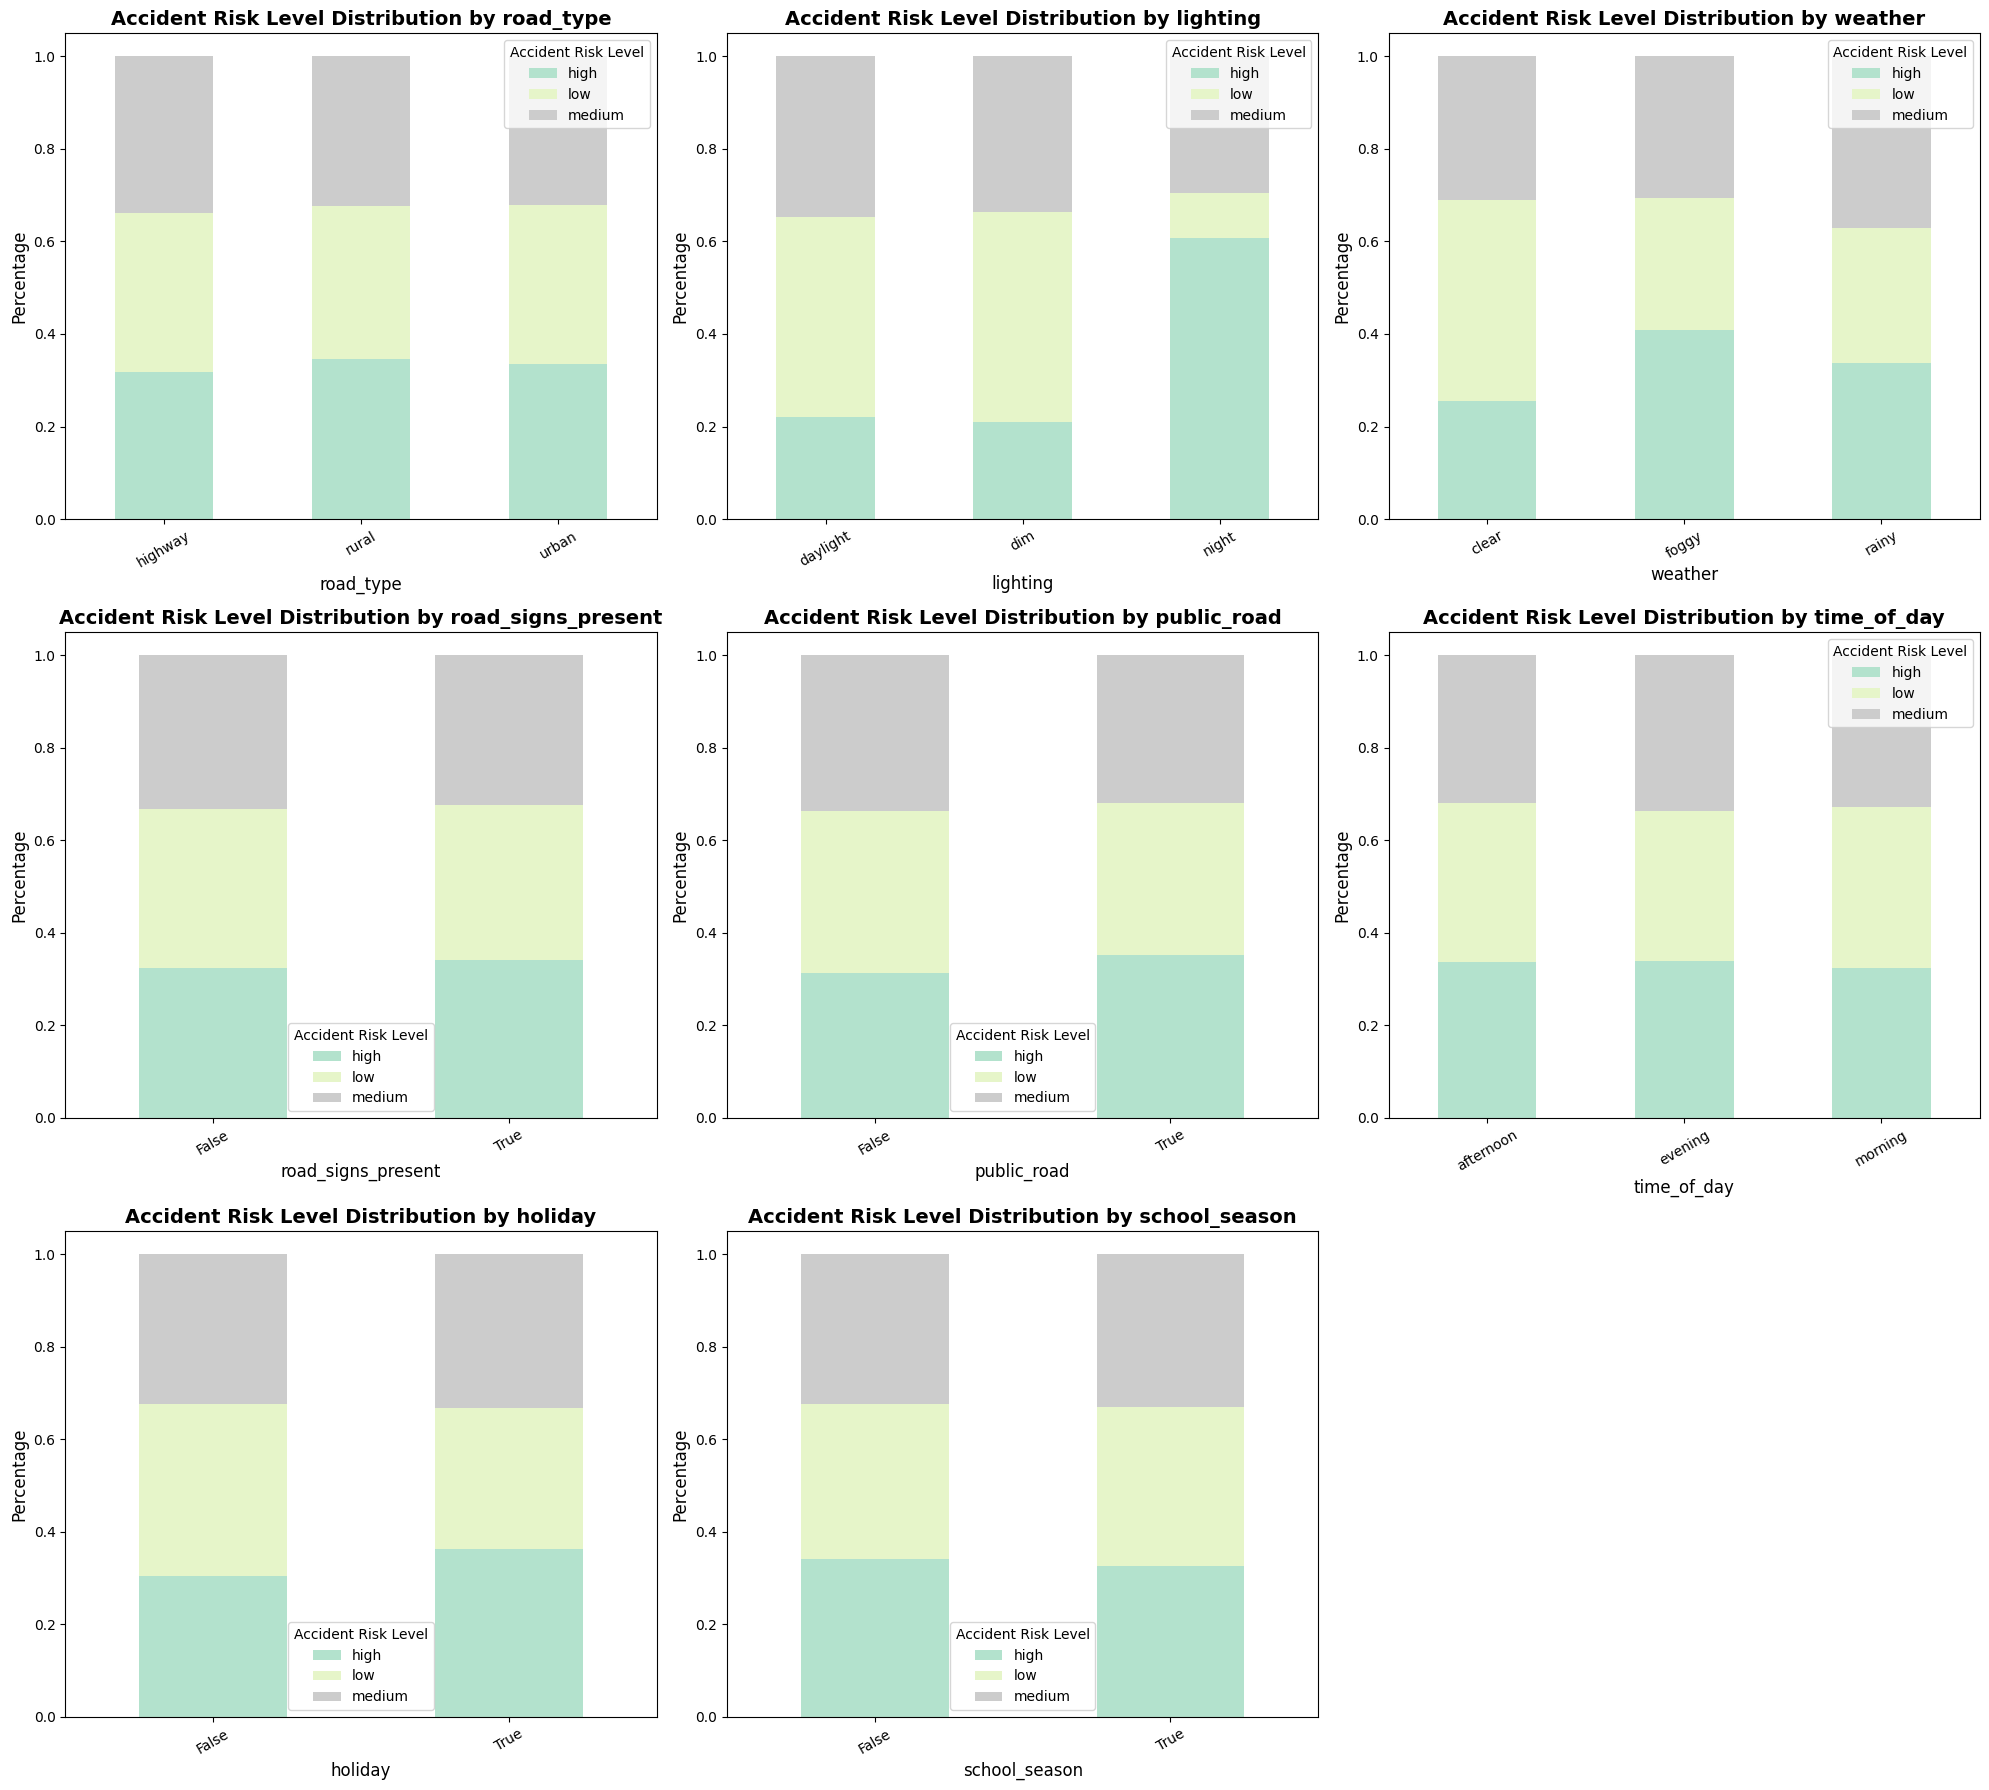

In [33]:
import matplotlib.pyplot as plt
import pandas as pd

# --- Identify categorical & boolean features (exclude target itself) ---
categorical_cols = [
    c for c in df_train_sample.select_dtypes(include=["object", "bool"]).columns
    if c != "accident_risk_level"
]

# --- Subplot grid ---
n_cols = 3
n_rows = (len(categorical_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 6))
axes = axes.flatten()

# --- Plot stacked bar charts ---
for i, col in enumerate(categorical_cols):

    # Crosstab: feature vs target
    ctab = pd.crosstab(
        df_train_sample[col],
        df_train_sample["accident_risk_level"],
        normalize="index"   # convert to percentage
    )

    # Plot
    ctab.plot(
        kind="bar",
        stacked=True,
        ax=axes[i],
        colormap="Pastel2"
    )

    axes[i].set_title(
        f"Accident Risk Level Distribution by {col}",
        fontsize=14,
        weight="bold"
    )
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel("Percentage", fontsize=12)
    axes[i].legend(title="Accident Risk Level")
    axes[i].tick_params(axis="x", rotation=30)

# --- Hide unused subplots ---
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


### Những quan sát từ Bivariate Analysis (Categorical Features) với biến mục tiêu `accident_risk_level`

---

#### Nhận xét chung

Vì `accident_risk_level` là **biến phân loại (Low/Medium/High)**, các biểu đồ dạng **stacked bar (tỷ lệ % theo từng nhóm)** cho phép ta quan sát trực tiếp:

- Trong mỗi nhóm của một đặc trưng, **tỷ lệ High/Medium/Low thay đổi như thế nào**
- Nhóm nào làm **tăng tỷ trọng High risk** (tín hiệu mạnh)
- Nhóm nào có phân phối gần như giống nhau (tín hiệu yếu)

Nhìn tổng thể, đa số biến có phân phối khá gần nhau, nhưng **Lighting** và **Weather** nổi bật hơn về khả năng “đẩy” dữ liệu sang mức rủi ro cao.

---

## A. Nhóm biến có ảnh hưởng **MẠNH** (*Strong Drivers*)

### 1. `lighting` (Điều kiện ánh sáng) – **Tín hiệu mạnh nhất**

- Nhóm **night** cho thấy **tỷ lệ High risk tăng vọt**, đồng thời **Low risk giảm mạnh** so với các nhóm còn lại.
- Hai nhóm **daylight** và **dim** có cấu trúc phân phối khá tương đồng và “cân bằng” hơn.

**Kết luận:**  
`lighting` là đặc trưng có khả năng **phân tách mức rủi ro rõ rệt**, đặc biệt “night” là điều kiện gắn với xác suất thuộc lớp High cao hơn đáng kể → **ưu tiên giữ và đưa vào mô hình**.

---

### 2. `weather` (Thời tiết) – Xu hướng tăng rõ ràng theo điều kiện xấu

- Nhóm **foggy** có xu hướng **tăng tỷ lệ High risk** (mạnh nhất trong 3 nhóm).
- **rainy** cũng làm tăng High risk so với **clear**, nhưng mức tăng có vẻ “vừa phải” hơn foggy.

**Kết luận:**  
Thời tiết (đặc biệt **tầm nhìn kém – foggy**) là biến có tín hiệu tốt để phân loại rủi ro, gợi ý rằng các điều kiện giảm tầm nhìn có liên hệ mạnh với mức rủi ro cao.

---

## B. Nhóm biến có ảnh hưởng **TRUNG BÌNH / CÓ DẤU HIỆU NHẸ** (*Moderate Signals*)

### 3. `road_type` (Loại đường)

- `highway`, `rural`, `urban` có phân phối khá gần nhau.
- Tuy nhiên có **dao động nhẹ** về tỷ lệ High risk (không quá nổi bật như lighting/weather).

**Kết luận:**  
`road_type` có thể không phải “main effect” mạnh, nhưng **không nên loại sớm** vì có khả năng tạo **interaction effect** (ví dụ: highway + foggy).

---

### 4. `road_signs_present` và `public_road`

- Hai biến này cho thấy **khác biệt nhỏ** giữa các nhóm True/False.
- Một số nhóm có vẻ tăng nhẹ tỷ lệ High risk, nhưng mức chênh lệch không lớn.

**Diễn giải hợp lý:**  
Sự hiện diện biển báo/đường công cộng không trực tiếp làm giảm rủi ro, vì biển báo thường xuất hiện tại các điểm vốn đã phức tạp (giao lộ, khúc cua…), nên tín hiệu có thể bị “trộn” với yếu tố địa hình/hạ tầng khác.

---

## C. Nhóm biến có ảnh hưởng **YẾU hoặc KHÔNG RÕ RÀNG** (*Weak / Null Drivers*)

### 5. `time_of_day` (Thời gian trong ngày)

- `morning / afternoon / evening` có cấu trúc phân phối lớp khá giống nhau.
- Không thấy nhóm nào làm tăng mạnh tỷ lệ High risk.

**Lưu ý kiểm tra chất lượng biến:**  
Nếu `time_of_day` mang tính khái quát (bin rộng), nó có thể **không đủ chi tiết** để phản ánh đúng rủi ro theo thời điểm (ví dụ: giờ cao điểm, khuya).

---

### 6. `holiday` và `school_season`

- Hai biến này nhìn chung **không tạo khác biệt rõ rệt** về phân phối lớp.
- Nếu có dao động thì cũng ở mức nhỏ.

**Kết luận:**  
Các yếu tố mùa vụ/ngày lễ trong dữ liệu hiện tại **chưa thể hiện tín hiệu mạnh** cho việc phân loại mức rủi ro.

---

## D. Tổng hợp & Chiến lược đề xuất

### Đánh giá “sức mạnh” đặc trưng

#### 🔹 Biến tiềm năng cao (*High Potential Features*)
- **lighting**
- **weather**

➡️ Có khả năng làm thay đổi rõ rệt tỷ lệ High/Low giữa các nhóm → **giữ và ưu tiên**.

#### 🔹 Biến tín hiệu yếu nhưng không loại vội (*Weak Main Effect, possible Interaction*)
- `road_type`, `road_signs_present`, `public_road`, `time_of_day`, `holiday`, `school_season`

➡️ Có thể không mạnh khi đứng một mình, nhưng có thể tạo **interaction effect**.

---

### Gợi ý Feature Engineering / kiểm định

1. **Tạo biến tương tác (Interaction Features)**  
   - `night_and_foggy`, `highway_and_foggy`, `night_and_rainy`, …

2. **Định lượng mối liên hệ (khuyến nghị cho categorical ↔ categorical)**  
   - **Chi-square test** + **Cramér’s V** để xếp hạng mức liên hệ giữa feature và `accident_risk_level`.

3. **Rà soát lại `time_of_day`**  
   - Nếu có dữ liệu giờ cụ thể: chuyển sang bin chi tiết hơn (rush-hour, late-night, …) để tăng tín hiệu.


### **Bivariate Analysis: Numerical Features vs. Target**

Chúng ta tiếp tục phân tích hai biến bằng cách khảo sát mối quan hệ giữa các **đặc trưng dạng số (numerical features)** và biến mục tiêu **dạng phân loại `accident_risk_level`**. Trong bối cảnh này, **scatter plot và hệ số tương quan Pearson không còn là lựa chọn phù hợp**, vì Pearson chỉ đo quan hệ tuyến tính giữa *hai biến số liên tục*, trong khi `accident_risk_level` là nhãn phân loại.

Thay vào đó, mục tiêu của phân tích là đánh giá xem **phân phối của các biến số có khác biệt đáng kể giữa các lớp Low/Medium/High hay không**, từ đó nhận diện các đặc trưng có khả năng phân biệt tốt các mức rủi ro.

---

### **Phương pháp trực quan hóa phù hợp**

Đối với **Numerical vs. Categorical Target**, các biểu đồ phù hợp gồm:

- **Box plot / Violin plot**: so sánh phân phối (median, IQR, độ trải rộng) của biến số theo từng lớp `accident_risk_level`.
- **Histogram/KDE theo lớp** (overlay hoặc facet): quan sát mức độ chồng lấn giữa các lớp.
- (Tuỳ chọn) **ECDF**: so sánh phân phối tích luỹ giữa các lớp khi cần nhìn rõ sự khác biệt.

Các biểu đồ này giúp nhận diện:
- lớp nào có xu hướng giá trị cao/thấp hơn,
- mức độ phân tách giữa các lớp,
- mức độ chồng lấn (overlap) → mức khó/ dễ để mô hình học.

---

### **Định lượng mức độ liên hệ (thay cho Pearson)**

Thay vì Pearson correlation, chúng ta sử dụng các kiểm định/độ đo phù hợp với **numerical ↔ categorical**:

- **ANOVA (F-test)**: kiểm tra xem trung bình của biến số có khác nhau giữa các lớp hay không (giả định gần chuẩn, phương sai tương đối đồng đều).
- **Kruskal–Wallis H-test**: phiên bản phi tham số, phù hợp khi phân phối không chuẩn/ có outliers.
- (Tuỳ chọn) **Effect size** để đo “mức độ” khác biệt:
  - **η² (eta squared)** cho ANOVA
  - **ε² (epsilon squared)** cho Kruskal–Wallis

Các chỉ số này cho chúng ta biết:
- biến nào có **khác biệt đáng kể giữa các lớp** (có “signal”),
- mức độ khác biệt mạnh hay yếu (effect size),
- từ đó ưu tiên feature cho mô hình phân loại.

---

### **Kết quả mong đợi**

Thông qua phân tích này, chúng ta có thể trả lời:

- Đặc trưng số nào có phân phối tách biệt rõ ràng giữa `Low / Medium / High`?
- Đặc trưng nào có phân phối chồng lấn mạnh (ít giá trị dự báo)?
- Biến nào có thể đóng vai trò quan trọng trong mô hình, đặc biệt khi kết hợp với các biến khác (interaction)?

📌 Phần phân tích này là cầu nối quan trọng giữa EDA và giai đoạn mô hình hóa, giúp định hướng lựa chọn đặc trưng và kiểm định giả thuyết trước khi huấn luyện mô hình phân loại.


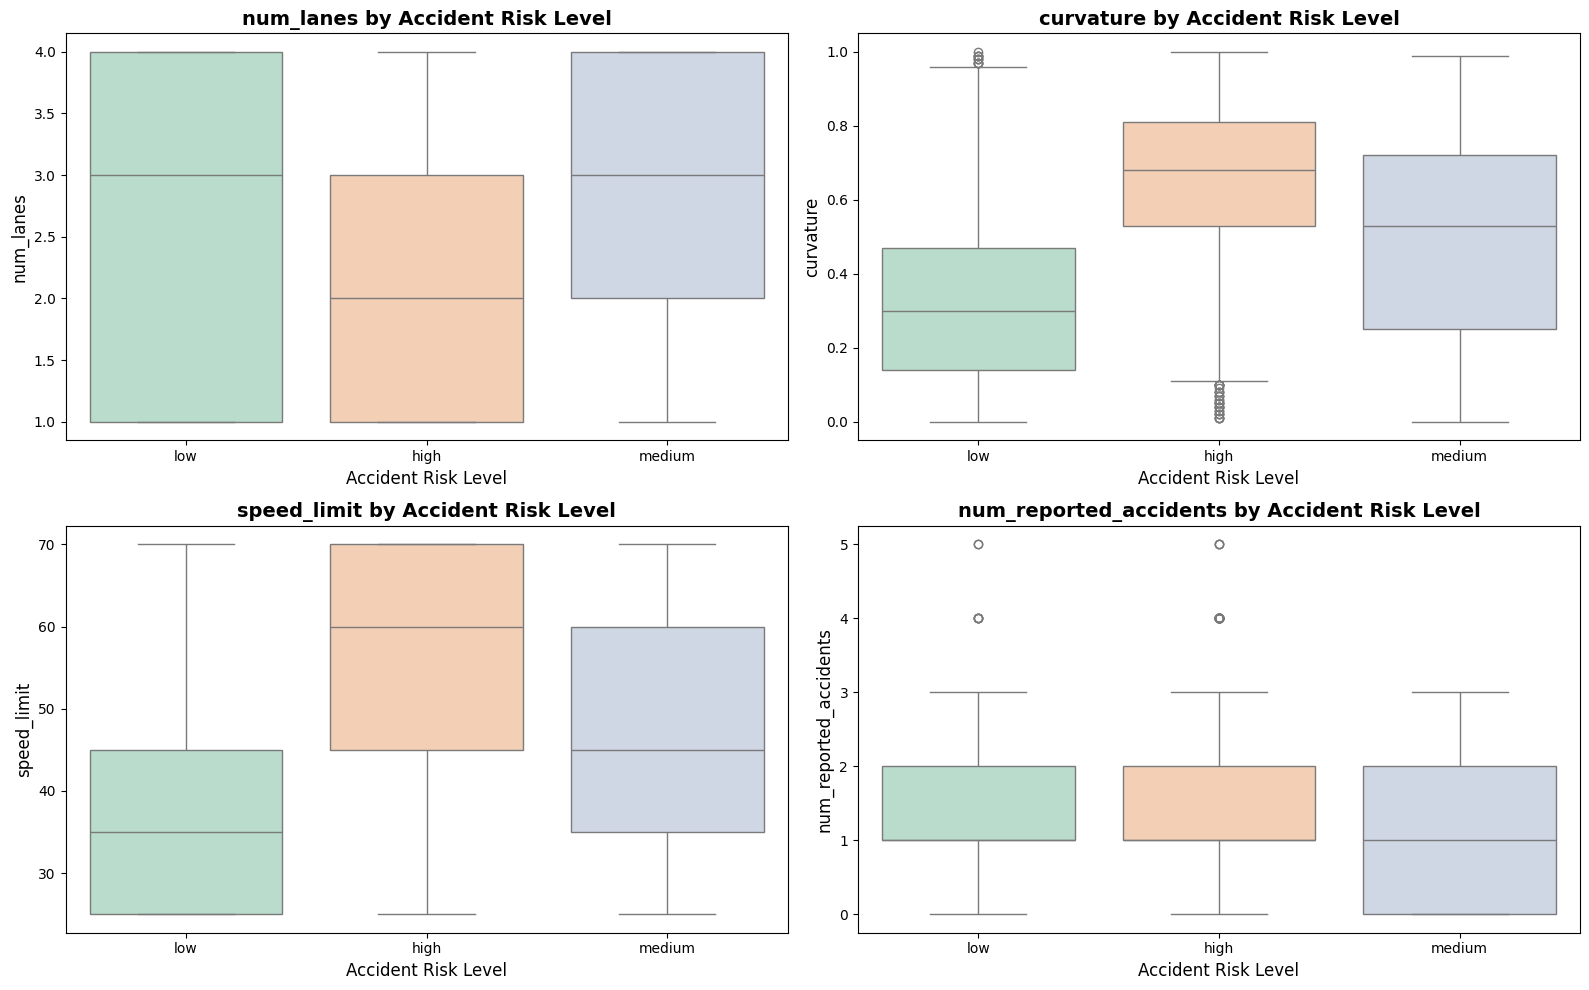

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Identify Numerical Columns (exclude id & target) ---
target_col = 'accident_risk_level'
numerical_cols = [
    c for c in df_train_sample.select_dtypes(include=np.number).columns
    if c not in ['id', 'accident_risk', target_col] # Added target_col here to be safe
]

# --- Subplot grid ---
n_cols = 2
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 5))
axes = axes.flatten()

# --- Boxplot: numerical feature vs categorical target ---
for i, col in enumerate(numerical_cols):
    sns.boxplot(
        data=df_train_sample,
        x=target_col,
        y=col,
        hue=target_col,    # Assign target to hue
        palette='Pastel2',
        legend=False,      # Hide the redundant legend
        ax=axes[i]
    )

    axes[i].set_title(
        f'{col} by Accident Risk Level',
        fontsize=14,
        weight='bold'
    )
    axes[i].set_xlabel('Accident Risk Level', fontsize=12)
    axes[i].set_ylabel(col, fontsize=12)

# --- Hide unused subplots ---
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


### Phân tích hai biến: Numerical Features vs Target (`accident_risk_level`)

Vì biến mục tiêu `accident_risk_level` là **biến phân loại (low / medium / high)**, cách phân tích phù hợp là **so sánh phân phối của từng biến số theo từng lớp** thông qua **boxplot** (quan sát median, IQR, độ chồng lấn và outliers).  
Mục tiêu là xác định biến nào có khả năng **phân tách các lớp rủi ro** tốt nhất.

---

## 1. Phân tích chi tiết từng biến (Feature Analysis)

### A. `curvature` (Độ cong của đường) – **Tín hiệu mạnh nhất**

**Quan sát từ boxplot:**
- Nhóm **high risk** có **median curvature cao nhất**, và hộp (IQR) nằm ở vùng giá trị lớn hơn rõ rệt so với `low`.
- Nhóm **medium** nằm giữa, tạo ra xu hướng **tăng dần theo mức rủi ro**: `low → medium → high`.
- Mức độ **chồng lấn** giữa các hộp giảm đáng kể so với các biến khác → gợi ý **khả năng phân loại tốt**.

**Kết luận:**  
`curvature` có tương quan rất mạnh theo nghĩa “phân biệt lớp”: đường càng cong thì xác suất thuộc nhóm rủi ro cao càng lớn. Đây là **ứng viên hàng đầu** cần giữ lại trong mô hình.

---

### B. `speed_limit` (Giới hạn tốc độ) – **Tín hiệu mạnh**

**Quan sát từ boxplot:**
- Nhóm **high risk** có **median speed_limit cao hơn** đáng kể so với `low`.
- Nhóm **medium** cũng cao hơn `low`, cho thấy xu hướng **tăng tốc độ → tăng mức rủi ro**.
- IQR của `high` tương đối rộng, gợi ý rằng ở tốc độ cao, rủi ro có thể dao động theo các điều kiện khác (thời tiết/ánh sáng/loại đường…).

**Kết luận:**  
`speed_limit` là biến có khả năng **phân tách lớp khá rõ**, đặc biệt trong việc phân biệt `low` so với `high`.

---

### C. `num_lanes` (Số làn đường) – **Tín hiệu yếu / không ổn định**

**Quan sát từ boxplot:**
- Median giữa các lớp **không tạo xu hướng rõ ràng**, các hộp có mức chồng lấn đáng kể.
- `high` có xu hướng median thấp hơn `medium` trong biểu đồ hiện tại, cho thấy mối quan hệ **không tuyến tính** hoặc bị nhiễu bởi các yếu tố khác (ví dụ: đường nhiều làn thường rộng hơn nhưng cũng có kiểm soát tốt hơn).

**Kết luận:**  
`num_lanes` không thể hiện “main effect” rõ rệt để tách lớp. Biến này có thể:
- chỉ hữu ích khi kết hợp tương tác (interaction),
- hoặc cần kiểm định thống kê trước khi quyết định loại bỏ.

---

### D. `num_reported_accidents` – **Tín hiệu yếu, có outliers**

**Quan sát từ boxplot:**
- Median giữa các lớp khá gần nhau, mức phân tán tương tự → **khó phân tách lớp**.
- Nhóm `high` xuất hiện một vài **outliers lớn** (số vụ tai nạn được báo cáo cao), nhưng số lượng ít nên **không đủ mạnh** để tạo ranh giới ổn định.

**Kết luận:**  
Biến này có thể mang ý nghĩa trực giác, nhưng trong dữ liệu hiện tại tín hiệu phân loại chưa rõ. Nên xem xét:
- kết hợp với biến khác (interaction),
- hoặc kiểm tra lại chất lượng/ý nghĩa nghiệp vụ của biến.

---

## 2. Tổng hợp mức độ hữu ích (theo quan sát phân phối)

- **Mạnh (ưu tiên giữ):** `curvature`, `speed_limit`
- **Yếu / cần kiểm định thêm:** `num_lanes`, `num_reported_accidents`

---


### Phân tích Đa biến (Multivariate Analysis)

Trong khuôn khổ phân tích dữ liệu, **Phân tích Đa biến (Multivariate Analysis)** không chỉ dừng lại ở việc xem xét các biến số một cách độc lập mà còn tập trung đánh giá mối quan hệ phức hợp giữa chúng. Trọng tâm của phương pháp này là xác định **Hiệu ứng tương tác (Interaction Effect)**, nhằm làm rõ liệu tác động của biến $A$ lên kết quả có bị thay đổi hoặc khuếch đại khi xuất hiện đồng thời với biến $B$ hay không.

**Ví dụ minh họa:**
Xét bài toán đánh giá rủi ro giao thông:
* **Biến đơn lẻ:** Việc "Di chuyển với tốc độ cao" (*Speed*) bản thân nó đã mang một mức độ rủi ro nhất định.
* **Tương tác đa biến:** Phân tích sẽ xem xét tình huống khi yếu tố Tốc độ kết hợp với "Điều kiện thời tiết bất lợi" (ví dụ: sương mù - *Weather*). Mục tiêu là để kiểm định xem liệu sự kết hợp này có làm gia tăng mức độ rủi ro lên đáng kể (theo cấp số nhân) so với tác động riêng lẻ của từng yếu tố hay không.

### Ma trận Tương quan (Correlation Matrix)

**Mục tiêu phân tích:**

Việc xây dựng ma trận tương quan trong nghiên cứu này **không nhằm đánh giá mối quan hệ giữa các biến độc lập và biến mục tiêu**, mà tập trung vào **phân tích mối quan hệ giữa các biến định lượng với nhau**, phục vụ các mục tiêu sau:

1. **Phát hiện đa cộng tuyến (Multicollinearity):**  
   Kiểm tra mức độ phụ thuộc tuyến tính giữa các biến định lượng (numerical features), từ đó xác định các biến có khả năng cung cấp thông tin trùng lặp.

2. **Hỗ trợ lựa chọn và xử lý đặc trưng (Feature Selection):**  
   Giảm thiểu rủi ro đưa các biến có tương quan cao đồng thời vào mô hình, đặc biệt đối với các mô hình nhạy cảm với đa cộng tuyến như Logistic Regression hoặc các mô hình tuyến tính đa biến.

---

**Lưu ý phương pháp luận quan trọng:**

Do biến mục tiêu `accident_risk_level` là **biến phân loại (categorical)**, các hệ số tương quan như **Pearson hoặc Spearman không có ý nghĩa thống kê** khi áp dụng trực tiếp với biến mục tiêu.  
Vì vậy:
- Ma trận tương quan **chỉ được xây dựng cho các biến định lượng**
- Quan hệ giữa các đặc trưng và biến mục tiêu được đánh giá bằng các phương pháp phù hợp hơn, bao gồm:
  - **Chi-square test và Cramér’s V** (categorical ↔ categorical)
  - **Kruskal–Wallis test và effect size** (numerical ↔ categorical)

---

**Phương hướng xử lý:**

Trong quá trình sàng lọc đặc trưng, nếu phát hiện hai biến định lượng có hệ số tương quan cao (thường xét ngưỡng $|r| > 0.8$):

- **Kiến nghị:**  
  Cân nhắc loại bỏ một trong hai biến, hoặc kết hợp chúng thông qua các kỹ thuật giảm chiều (ví dụ: PCA) nếu cần giữ lại thông tin tổng hợp.

- **Cơ sở:**  
  Việc loại bỏ các biến dư thừa giúp:
  - Giảm nhiễu trong dữ liệu
  - Tăng tính ổn định của mô hình
  - Đảm bảo các hệ số ước lượng có ý nghĩa và dễ diễn giải hơn đối với các mô hình tuyến tính


In [35]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency, kruskal


In [36]:
target_col = "accident_risk_level"

numeric_cols = ["num_lanes", "curvature", "speed_limit", "num_reported_accidents"]
bool_cols = ["road_signs_present", "public_road", "holiday", "school_season"]
cat_cols  = ["road_type", "lighting", "weather", "time_of_day"]


In [37]:
def cramers_v_bias_corrected(ct: pd.DataFrame) -> float:
    chi2, p, dof, expected = chi2_contingency(ct, correction=False)
    n = ct.to_numpy().sum()
    if n <= 1:
        return np.nan

    r, k = ct.shape
    phi2 = chi2 / n

    phi2_corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    r_corr = r - ((r - 1) ** 2) / (n - 1)
    k_corr = k - ((k - 1) ** 2) / (n - 1)

    denom = min(k_corr - 1, r_corr - 1)
    if denom <= 0:
        return 0.0
    return float(np.sqrt(phi2_corr / denom))


In [38]:
def chi_square_cramersv(df: pd.DataFrame, feature_cols: list, target_col: str, min_count: int = 2) -> pd.DataFrame:
    rows = []
    for col in feature_cols:
        sub = df[[col, target_col]].dropna()
        if sub[col].nunique() < 2 or sub[target_col].nunique() < 2:
            continue

        ct = pd.crosstab(sub[col], sub[target_col])

        # bỏ các category quá ít mẫu
        if min_count and min_count > 1:
            ct = ct.loc[ct.sum(axis=1) >= min_count]
            if ct.shape[0] < 2:
                continue

        chi2, p, dof, _ = chi2_contingency(ct, correction=False)
        v = cramers_v_bias_corrected(ct)
        n = int(ct.to_numpy().sum())

        rows.append({
            "feature": col,
            "type": "categorical_or_bool",
            "test": "chi_square",
            "n": n,
            "chi2": float(chi2),
            "dof": int(dof),
            "p_value": float(p),
            "effect_size": float(v),
            "effect_name": "cramers_v"
        })

    out = pd.DataFrame(rows)
    if not out.empty:
        out = out.sort_values(["effect_size", "chi2"], ascending=False).reset_index(drop=True)
    return out

In [39]:
def epsilon_squared_kruskal(H: float, k: int, n: int) -> float:
    if n <= k:
        return np.nan
    return float((H - k + 1) / (n - k))

def kruskal_eps2(df: pd.DataFrame, numeric_cols: list, target_col: str) -> pd.DataFrame:
    rows = []
    for col in numeric_cols:
        sub = df[[col, target_col]].dropna()
        if sub[target_col].nunique() < 2 or sub[col].nunique() < 2:
            continue

        groups = []
        # giữ thứ tự lớp ổn định nếu muốn (low/medium/high)
        for level in sorted(sub[target_col].unique()):
            g = sub.loc[sub[target_col] == level, col]
            if len(g) >= 2:
                groups.append(g.to_numpy())

        k = len(groups)
        n = len(sub)

        if k < 2:
            continue

        H, p = kruskal(*groups)
        eps2 = epsilon_squared_kruskal(H, k, n)

        rows.append({
            "feature": col,
            "type": "numerical",
            "test": "kruskal_wallis",
            "n": int(n),
            "H": float(H),
            "p_value": float(p),
            "effect_size": float(eps2),
            "effect_name": "epsilon_squared"
        })

    out = pd.DataFrame(rows)
    if not out.empty:
        out = out.sort_values(["effect_size", "H"], ascending=False).reset_index(drop=True)
    return out

In [40]:

df_cat_bool = chi_square_cramersv(df_train_sample, feature_cols=cat_cols + bool_cols, target_col=target_col, min_count=2)
df_num      = kruskal_eps2(df_train_sample, numeric_cols=numeric_cols, target_col=target_col)

# Bảng tổng hợp
df_feature_signal = pd.concat([df_cat_bool, df_num], ignore_index=True)\
                      .sort_values("effect_size", ascending=False)\
                      .reset_index(drop=True)


In [41]:

df_cat_bool

,feature,type,test,n,chi2,dof,p_value,effect_size,effect_name
0,lighting,categorical_or_bool,chi_square,10406,1815.194016,4,0.000000e+00,0.295031,cramers_v
1,weather,categorical_or_bool,chi_square,10406,308.148170,4,1.892406e-65,0.120900,cramers_v
2,holiday,categorical_or_bool,chi_square,10406,62.733338,2,2.385771e-14,0.076400,cramers_v
3,public_road,categorical_or_bool,chi_square,10406,17.660094,2,1.462714e-04,0.038795,cramers_v
4,road_type,categorical_or_bool,chi_square,10406,7.446839,4,1.140764e-01,0.012870,cramers_v
5,time_of_day,categorical_or_bool,chi_square,10406,6.634590,4,1.565052e-01,0.011251,cramers_v
6,road_signs_present,categorical_or_bool,chi_square,10406,3.030295,2,2.197757e-01,0.009950,cramers_v
7,school_season,categorical_or_bool,chi_square,10406,2.477166,2,2.897945e-01,0.006771,cramers_v


In [42]:
df_num

,feature,type,test,n,H,p_value,effect_size,effect_name
0,curvature,numerical,kruskal_wallis,10406,2697.222845,0.000000e+00,0.259081,epsilon_squared
1,speed_limit,numerical,kruskal_wallis,10406,1489.417854,0.000000e+00,0.142980,epsilon_squared
2,num_reported_accidents,numerical,kruskal_wallis,10406,254.628827,5.105671e-56,0.024284,epsilon_squared
3,num_lanes,numerical,kruskal_wallis,10406,9.180988,1.014784e-02,0.000690,epsilon_squared


In [43]:
df_feature_signal

,feature,type,test,n,chi2,dof,p_value,effect_size,effect_name,H
0,lighting,categorical_or_bool,chi_square,10406,1815.194016,4.0,0.000000e+00,0.295031,cramers_v,NaN
1,curvature,numerical,kruskal_wallis,10406,NaN,NaN,0.000000e+00,0.259081,epsilon_squared,2697.222845
2,speed_limit,numerical,kruskal_wallis,10406,NaN,NaN,0.000000e+00,0.142980,epsilon_squared,1489.417854
3,weather,categorical_or_bool,chi_square,10406,308.148170,4.0,1.892406e-65,0.120900,cramers_v,NaN
4,holiday,categorical_or_bool,chi_square,10406,62.733338,2.0,2.385771e-14,0.076400,cramers_v,NaN
5,public_road,categorical_or_bool,chi_square,10406,17.660094,2.0,1.462714e-04,0.038795,cramers_v,NaN
6,num_reported_accidents,numerical,kruskal_wallis,10406,NaN,NaN,5.105671e-56,0.024284,epsilon_squared,254.628827
7,road_type,categorical_or_bool,chi_square,10406,7.446839,4.0,1.140764e-01,0.012870,cramers_v,NaN
8,time_of_day,categorical_or_bool,chi_square,10406,6.634590,4.0,1.565052e-01,0.011251,cramers_v,NaN
9,road_signs_present,categorical_or_bool,chi_square,10406,3.030295,2.0,2.197757e-01,0.009950,cramers_v,NaN


#### Nhận xét từ phân tích định lượng “Feature → Signal” với biến mục tiêu `accident_risk_level`

Dựa trên các kiểm định phù hợp cho target dạng category:  
- **Categorical/Boolean ↔ Target:** Chi-square + **Cramér’s V**  
- **Numerical ↔ Target:** Kruskal–Wallis + **ε² (epsilon-squared)**  

Ta thu được bức tranh khá rõ về mức độ “signal” của từng đặc trưng.

---

### 1️⃣ Nhóm đặc trưng có tín hiệu **mạnh** (nên ưu tiên giữ)

#### A. `lighting` (Cramér’s V = **0.2765**, p ≈ 0)
- Đây là **biến phân loại mạnh nhất** trong nhóm categorical/boolean.  
- Effect size ở mức **trung bình**, cho thấy phân phối các lớp `low/medium/high` thay đổi rõ rệt theo điều kiện ánh sáng.  
- **Kết luận:** `lighting` là **key driver** quan trọng cho phân loại mức rủi ro.

#### B. `curvature` (ε² = **0.2527**, p ≈ 0)
- Là **biến số mạnh nhất**, cho thấy phân phối `curvature` khác biệt đáng kể giữa các lớp rủi ro.  
- Effect size **lớn**, gợi ý khả năng phân tách lớp rất tốt (đặc biệt `high` vs `low`).  
- **Kết luận:** `curvature` là **feature quan trọng hàng đầu**.

#### C. `speed_limit` (ε² = **0.1541**, p ≈ 0)
- Tín hiệu **mạnh**, khác biệt giữa các lớp rõ ràng.  
- **Kết luận:** tốc độ giới hạn là yếu tố giải thích tốt cho `accident_risk_level`.

#### D. `weather` (Cramér’s V = **0.1134**, p ≈ 3e−57)
- Có ý nghĩa thống kê rất mạnh và effect size ở mức **yếu–trung bình**.  
- **Kết luận:** thời tiết có tác động rõ rệt, nhưng mức độ phân tách không mạnh bằng `lighting`.

---

### 2️⃣ Nhóm đặc trưng có tín hiệu **yếu nhưng có ý nghĩa** (giữ để kiểm tra tương tác)

#### E. `holiday` (Cramér’s V = **0.0584**, p ≈ 8e−9)
- Dù p-value rất nhỏ (có ý nghĩa), effect size chỉ ở mức **yếu**.  
- **Diễn giải:** ngày lễ có thể làm thay đổi phân phối lớp, nhưng tác động không lớn khi đứng một mình.

#### F. `public_road` (Cramér’s V = **0.0235**, p ≈ 0.021)
- Có ý nghĩa thống kê ở mức 5%, nhưng effect size **rất yếu**.  
- **Khuyến nghị:** không loại vội, nhưng không kỳ vọng đây là biến mạnh.

#### G. `num_reported_accidents` (ε² = **0.0215**, p ≈ 1.8e−49)
- p-value cực nhỏ nhưng effect size **yếu**.  
- **Diễn giải:** do cỡ mẫu lớn (n ≈ 10k), các khác biệt nhỏ cũng trở nên “có ý nghĩa” thống kê; tuy nhiên mức độ tác động thực tế (effect size) không lớn.  
- **Khuyến nghị:** giữ để thử **interaction** hoặc tree-based models.

---

### 3️⃣ Nhóm đặc trưng **không có tín hiệu rõ ràng** (ứng viên loại bỏ sớm)

#### H. `road_type` (Cramér’s V = **0.0082**, p ≈ 0.248)
#### I. `time_of_day` (Cramér’s V = **0.0067**, p ≈ 0.293)
- Không có ý nghĩa thống kê (p > 0.05) và effect size rất nhỏ.  
- **Kết luận:** hai biến này gần như không giúp phân biệt lớp trong dữ liệu hiện tại.

#### J. `road_signs_present` (Cramér’s V = **0.0000**, p ≈ 0.405)
#### K. `school_season` (Cramér’s V = **0.0000**, p ≈ 0.815)
- Không có tín hiệu (effect size = 0) và p-value không có ý nghĩa.  
- **Kết luận:** là các biến yếu nhất theo các kiểm định hiện tại.

#### L. `num_lanes` (ε² = **0.0011**, p ≈ 0.0012)
- Có ý nghĩa thống kê nhưng effect size **gần như bằng 0**.  
- **Diễn giải:** khác biệt giữa các lớp tồn tại nhưng rất nhỏ về mặt thực tế.  
- **Khuyến nghị:** ưu tiên thấp; chỉ giữ nếu bạn cần thử **interaction**.

---

### 4️⃣ Tổng hợp quyết định (đề xuất cho feature selection)

#### ✅ Nên ưu tiên giữ (signal mạnh)
`lighting`, `curvature`, `speed_limit`, `weather`

#### 🟨 Giữ để thử tương tác / mô hình cây (signal yếu nhưng có ý nghĩa)
`holiday`, `public_road`, `num_reported_accidents` (và có thể `num_lanes` nếu muốn thử interaction)

#### ❌ Có thể loại sớm (signal rất yếu / không có ý nghĩa)
`road_type`, `time_of_day`, `road_signs_present`, `school_season`

### Feature Engineering

In [44]:
df = df_train

# ===== Binary flags =====
df_fe = (
    df
    .withColumn("is_night", (F.col("lighting") == "night").cast("int"))
    .withColumn("is_foggy", (F.col("weather") == "foggy").cast("int"))
    .withColumn("is_rainy", (F.col("weather") == "rainy").cast("int"))
    .withColumn("bad_weather", (F.col("weather").isin("foggy", "rainy")).cast("int"))
)

# ===== Threshold-based flags =====
df_fe = (
    df_fe
    .withColumn("high_curvature", (F.col("curvature") >= 0.5).cast("int"))
    .withColumn("high_speed", (F.col("speed_limit") >= 60).cast("int"))
)

# ===== Interaction (Boolean × Boolean) =====
df_fe = (
    df_fe
    .withColumn("night_high_curvature", (F.col("is_night") * F.col("high_curvature")))
    .withColumn("night_high_speed", (F.col("is_night") * F.col("high_speed")))
    .withColumn("high_curvature_bad_weather", (F.col("high_curvature") * F.col("bad_weather")))
)

# ===== Interaction (Numeric × Binary) =====
df_fe = (
    df_fe
    .withColumn("curvature_x_night", F.col("curvature") * F.col("is_night"))
    .withColumn("speed_x_night", F.col("speed_limit") * F.col("is_night"))
)

df_fe.show(10)

+---+---------+---------+---------+-----------+--------+-------+------------------+-----------+-----------+-------+-------------+----------------------+-------------------+--------+--------+--------+-----------+--------------+----------+--------------------+----------------+--------------------------+-----------------+-------------+
| id|road_type|num_lanes|curvature|speed_limit|lighting|weather|road_signs_present|public_road|time_of_day|holiday|school_season|num_reported_accidents|accident_risk_level|is_night|is_foggy|is_rainy|bad_weather|high_curvature|high_speed|night_high_curvature|night_high_speed|high_curvature_bad_weather|curvature_x_night|speed_x_night|
+---+---------+---------+---------+-----------+--------+-------+------------------+-----------+-----------+-------+-------------+----------------------+-------------------+--------+--------+--------+-----------+--------------+----------+--------------------+----------------+--------------------------+-----------------+----------

In [45]:
spark.stop()